In [1]:
import os
import pathlib
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from multiprocessing import Pool
import psutil
from climatenet.utils.data import ClimateDataset
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events
import torch
import numpy as np
from os import path
from sklearn.metrics import jaccard_score
from climatenet.procrustes_loss_new import ProcrustesLossBag


config = Config('/home/sbk29/data/github_AR/AR_detection/climatenet/config_new.json')
model = CGNet(config)

In [2]:
import jax
print(jax.devices())      # should list your GPU


[CudaDevice(id=0)]


In [3]:
import jax, jax.numpy as jnp
print(jax.devices())          # should list your GPU
x = jnp.ones((2, 2))
print(jnp.tanh(x))            # simple op to confirm everything works


[CudaDevice(id=0)]
[[0.7615942 0.7615942]
 [0.7615942 0.7615942]]


In [3]:
from torch.utils.data import Dataset, DataLoader
config = Config('/home/sbk29/data/github_AR/AR_detection/climatenet/config_new.json')
model = CGNet(config)
labeled_dataset_test = ClimateDatasetLabeled('/home/sbk29/data/AR/test', model.config)
labeled_dataset_val = ClimateDatasetLabeled('/home/sbk29/data/AR/validation', model.config)
labeled_dataset_test_val = ClimateDatasetLabeled('/home/sbk29/data/AR/test_val', model.config)

test_val_loader = DataLoader(labeled_dataset_test_val, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
test_loader = DataLoader(labeled_dataset_test, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
val_loader = DataLoader(labeled_dataset_val, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
true_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(test_val_loader):
    # Move data to the same device as the model
    # input_images = input_images.to(device)
    # labels = labels.to(device)
    true_mask.append(labels)



In [10]:
val_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(val_loader):
    # Move data to the same device as the model
    # input_images = input_images.to(device)
    # labels = labels.to(device)
    val_mask.append(labels)
val_mask = np.array(val_mask)

In [11]:
val_mask.shape


(30, 1, 768, 1152)

In [4]:
true_mask = np.array(true_mask)

In [5]:
true_mask.shape

(61, 1, 768, 1152)

In [11]:
# config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
# print(config.num_classes)  # should be 3
# cgnet = CGNet(config)


training_set = ClimateDatasetLabeled('/home/sbk29/data/AR/train', model.config)
inference_set = ClimateDataset('/home/sbk29/data/AR/test_val', model.config)

# local_state_dict = torch.load('/home/sbk29/data/ClimateNet/weights.pth', map_location="cuda", weights_only=True)


model.load_model(weight_path = '/home/sbk29/data/ClimateNet/climatenet/weights/weights_new.pth', config_path = "/home/sbk29/data/github_AR/AR_detection/climatenet/weights/config_new.json")




In [12]:
test_set = ClimateDataset('/home/sbk29/data/AR/test', model.config)

In [13]:
import torch
torch.cuda.empty_cache()


In [14]:
predictions_test = model.predict(test_set)

 25%|██▌       | 1/4 [00:00<00:02,  1.26it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 2/4 [00:01<00:01,  1.72it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 3/4 [00:01<00:00,  1.95it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

Output shape : torch.Size([7, 2, 768, 1152])
(7, 2, 768, 1152)


In [15]:
predictions = model.predict(inference_set)
print(predictions.shape)

  0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 4, 3, 3], expected input[8, 1, 770, 1154] to have 4 channels, but got 1 channels instead

In [ ]:
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
# print(config.num_classes)  # should be 3
cgnet = CGNet(config)

train_path = '/home/sbk29/data/AR/'
train_dataset = ClimateDatasetLabeled(path.join(train_path, 'train'), config)
cgnet.train_procrustes(train_dataset)

In [6]:
cgnet.save_model('/home/sbk29/data/ClimateNet/climatenet/weights/')

In [7]:
predictions = np.array(predictions)

In [8]:
from scipy.special import softmax
predictions_softmax = softmax(predictions, axis=1)

In [10]:
predictions_softmax.shape

(61, 2, 768, 1152)

In [9]:
true_mask = np.array(true_mask)


In [13]:
predictions.shape

(61, 2, 768, 1152)

In [10]:
predictions_prob =  1/(1+np.exp(-predictions[:,1,:,:]))  

In [15]:
predictions_prob.shape

(61, 768, 1152)

In [11]:
predicted_mask = predictions_softmax[:,1,:,:] > 0.5

In [17]:
predicted_mask.shape

(61, 768, 1152)

In [17]:
np.unique(predicted_mask)

array([False,  True])

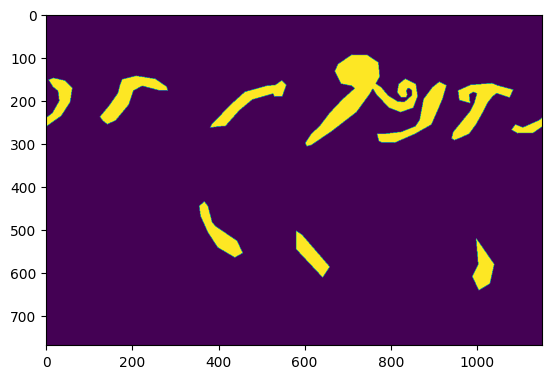

In [12]:
plt.imshow(true_mask[1,0,:,:])

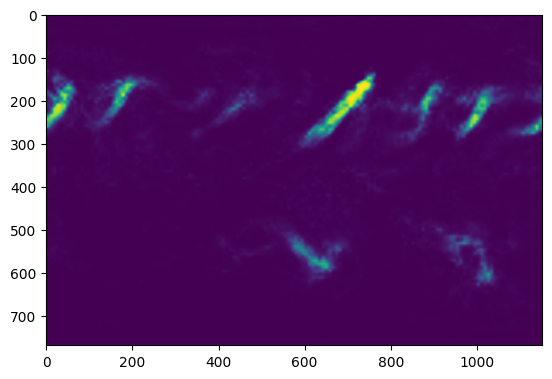

In [15]:
plt.imshow(predictions_softmax[1,1,:,:])

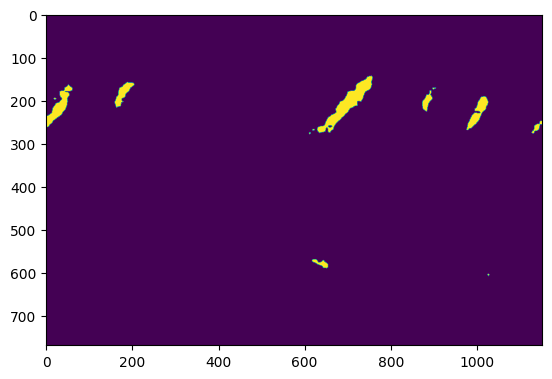

In [16]:
plt.imshow(predicted_mask[1,:,:])

In [21]:
(np.min(predictions))


-53.256664

In [17]:
score = (predictions_test[:, 1] - predictions_test[:, 0])

In [18]:
score = np.array(score)

In [31]:
score.shape

(31, 768, 1152)

In [19]:
test_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(test_loader):
    # Move data to the same device as the model
    # input_images = input_images.to(device)
    # labels = labels.to(device)
    test_mask.append(labels)

test_mask = np.array(test_mask)

In [20]:
# logits: (N,H,W)  float32 or float64
# y_true: (N,H,W)  int {0,1}

z = score.reshape(-1)          # (N·H·W,)
y = test_mask.reshape(-1)          # same length

In [24]:
y.shape

(27426816,)

In [25]:
z.shape

(27426816,)

In [21]:
N, H, W = score.shape

In [35]:
import numpy as np, pymc as pm, pytensor.tensor as pt
import arviz as az

# OPTIONAL: subsample to keep MCMC fast if you have millions of pixels
N_pos = np.sum(y)
N_neg = y.size - N_pos
k     = 60_000                    # 30k + 30k is plenty for 2 parameters

pos_idx = np.where(y == 1)[0][:k//2]
neg_idx = np.where(y == 0)[0][:k//2]
sel     = np.concatenate([pos_idx, neg_idx])

z_sub = z[sel].astype("float32")
y_sub = y[sel].astype("int8")


JAX implementation on Bayesian Logistic Regression

In [22]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# 1) Send your data to the GPU
#    z: logits, shape (Npix,)
#    y: labels 0/1, same shape
z_flat = jnp.asarray(z.astype("float32"))
y_flat = jnp.asarray(y.astype("int32"))

# 2) Define the Platt‐scaling model
def platt_model(z, y=None):
    A = numpyro.sample("A", dist.Normal(0.0, 10.0))
    B = numpyro.sample("B", dist.Normal(0.0, 10.0))
    logits = A * z + B
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

# 3) Set up and run NUTS on the GPU
kernel = NUTS(platt_model, target_accept_prob=0.9)
mcmc   = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key = jax.random.PRNGKey(0)

mcmc.run(rng_key, z=z_flat, y=y_flat)
mcmc.print_summary()   # shows mean, sd, R-hat, ESS for A and B

# 4) Extract posterior samples of A, B
posterior = mcmc.get_samples()
A_draws   = posterior["A"]   # shape (1000,)
B_draws   = posterior["B"]

# # 5) (Optional) Compute calibrated probabilities on the GPU
# def get_posterior_probs(z):
#     # z: shape (Npix,)
#     logits = A_draws[:, None] * z + B_draws[:, None]   # (draws, Npix)
#     return jax.nn.sigmoid(logits)

# p_post = get_posterior_probs(z_flat)   # stays on GPU, shape (1000, Npix)
# p_med  = jnp.median(p_post, axis=0)    # (Npix,)
# p_lo   = jnp.quantile(p_post, 0.025, axis=0)
# p_hi   = jnp.quantile(p_post, 0.975, axis=0)

# # 6) Bring results back to NumPy and reshape to (N, H, W)
# p_med  = np.asarray(p_med).reshape(N, H, W)
# p_lo   = np.asarray(p_lo).reshape(N, H, W)
# p_hi   = np.asarray(p_hi).reshape(N, H, W)


/tmp/ipykernel_2414606/4035939089.py:23: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc   = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
warmup:  20%|██        | 408/2000 [00:12<00:33, 48.02it/s, 43 steps of size 2.16e-02. acc. prob=0.88] 

sample: 100%|██████████| 2000/2000 [00:43<00:00, 45.57it/s, 3 steps of size 6.19e-02. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.12      0.00      1.12      1.12      1.12    415.72      1.00
         B      1.91      0.00      1.91      1.90      1.91    392.64      1.00

Number of divergences: 0


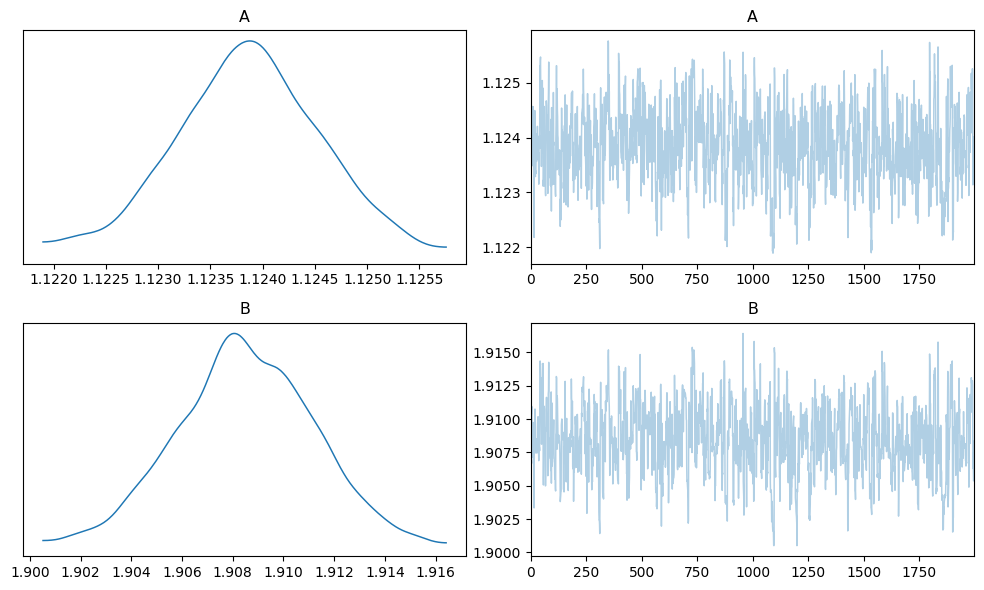

In [24]:
import arviz as az# alternative: direct from raw samples
samples = mcmc.get_samples()  # dict with "A" and "B"
az.plot_trace({"A": samples["A"], "B": samples["B"]}, figsize=(10,6))
plt.tight_layout()
plt.show()


In [25]:
A_hat = np.mean(A_draws)

In [26]:
B_hat = np.mean(B_draws)

In [27]:
p_hat = 1/ (1 + np.exp(-(A_hat * z + B_hat)))

In [28]:
p_hat = p_hat.reshape(N, H, W)

In [29]:
# Compute the 2.5 and 97.5 percentiles
A_low, A_high = np.percentile(A_draws, [2.5, 97.5])
B_low, B_high = np.percentile(B_draws, [2.5, 97.5])

In [30]:
A_high

1.125172746181488

In [31]:
p_low = 1/ (1 + np.exp(-(A_low * z + B_low)))
p_high = 1/ (1 + np.exp(-(A_high * z + B_high)))

In [32]:
p_low = p_low.reshape(N,H,W)
p_high = p_high.reshape(N,H,W)

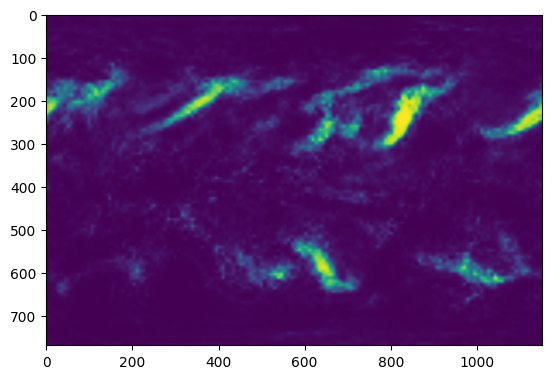

In [35]:
plt.imshow(p_high[10,:,:])


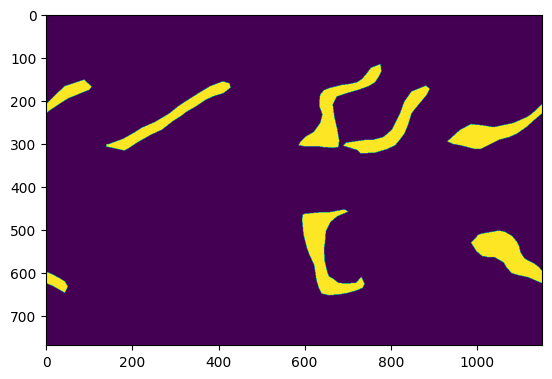

In [36]:
plt.imshow(test_mask[10,0,:,:])

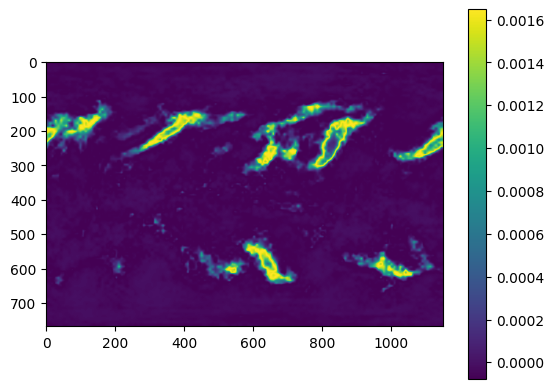

In [34]:
plt.imshow(p_high[10,:,:] - p_low[10,:,:])
plt.colorbar()

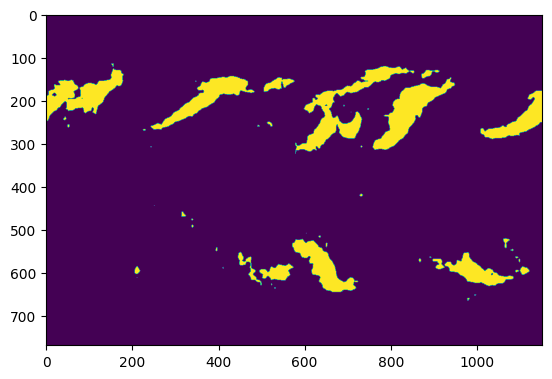

In [38]:
plt.imshow(p_high[10,:,:]>0.2)

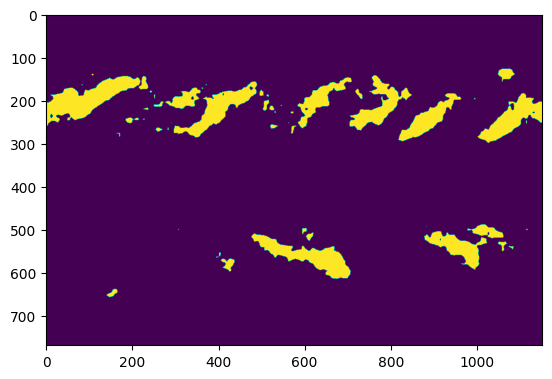

In [55]:
plt.imshow(p_hat[0,:,:]>0.2)

In [39]:
z_flat = z_flat.reshape(-1, 1)
y_flat = y_flat.reshape(-1)


In [57]:
z_sub

array([-3.3592796, -3.6830568, -3.5937858, ..., -5.326233 , -5.3811035,
       -5.435974 ], dtype=float32)

In [58]:
y_sub

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [59]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# z_sub, y_sub are your balanced subsample (e.g. 10 000 pixels)
lr = LogisticRegression(C=1e3, solver="lbfgs").fit(z_sub.reshape(-1, 1), y_sub)

A_hat = lr.coef_[0, 0]
B_hat = lr.intercept_[0]


In [30]:
print(f'A_hat : {A_hat}, B_hat : {B_hat}')

A_hat : 0.3184807760964377, B_hat : 2.3310259959013666


In [38]:
from sklearn.utils import resample

n_boot  = 1_000
A_draws = np.empty(n_boot, dtype="float32")
B_draws = np.empty_like(A_draws)

for i in range(n_boot):
    z_b, y_b = resample(z_sub, y_sub)
    lr_b = lr.fit(z_b.reshape(-1,1), y_b)
    A_draws[i] = lr_b.coef_[0,0]
    B_draws[i] = lr_b.intercept_[0]


In [30]:
import numpy as np
import statsmodels.api as sm
from scipy.special import expit                # ← sigmoid

# 1. design matrix (intercept + z)
X = sm.add_constant(z[:, None])                # shape (Npix, 2)
model = sm.Logit(y, X).fit(disp=False)

# 2. point prediction
eta   = X @ model.params                       # log-odds
p_hat = expit(eta)                             # probability  (same as model.predict(X))

# 3. delta-method 95 % CI
cov_beta = model.cov_params()           # 2×2 matrix
var_eta  = np.einsum("ij,jk,ik->i", X, cov_beta, X)
se_p     = np.sqrt(var_eta) * p_hat * (1 - p_hat)

z95      = 1.96
ci_low   = p_hat - z95 * se_p
ci_high  = p_hat + z95 * se_p


In [34]:
model.params

array([-2.08638382,  0.11803463])

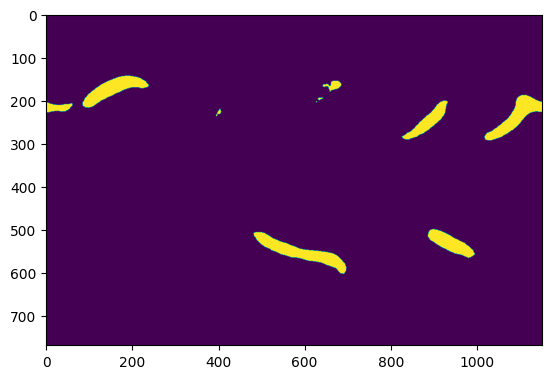

In [44]:
plt.imshow(ci_low.reshape(31, 768, 1152)[0,:,:]>0.5)

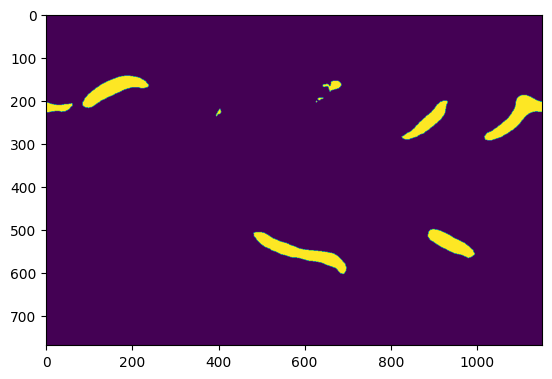

In [43]:
plt.imshow(ci_high.reshape(31, 768, 1152)[0,:,:]>0.5)

In [63]:
import arviz as az
import numpy as np

summary = az.summary(trace, var_names=["A", "B"], hdi_prob=0.95)

A_med  = summary.loc["A", "mean"]
A_low  = summary.loc["A", "hdi_2.5%"]
A_high = summary.loc["A", "hdi_97.5%"]

B_med  = summary.loc["B", "mean"]
B_low  = summary.loc["B", "hdi_2.5%"]
B_high = summary.loc["B", "hdi_97.5%"]


NameError: name 'trace' is not defined

In [61]:
test_mask.shape

(31, 1, 768, 1152)

In [62]:
N, S, H, W = test_mask.shape
# logits z  is 1-D  float32;  reshape(-1) earlier
z = z.astype("float32")

# point (posterior-mean) prediction
p_med = 1 / (1 + np.exp(-(A_med * z + B_med)))

# evaluate the four corner pairs
eta_11 = A_low  * z + B_low
eta_12 = A_low  * z + B_high
eta_21 = A_high * z + B_low
eta_22 = A_high * z + B_high

p_low  = 1 / (1 + np.exp(-np.maximum.reduce([eta_11, eta_12, eta_21, eta_22])))
p_high = 1 / (1 + np.exp(-np.minimum.reduce([eta_11, eta_12, eta_21, eta_22])))

# reshape back to (N, H, W)
p_med  = p_med.reshape(N, H, W)
p_low  = p_low.reshape(N, H, W)
p_high = p_high.reshape(N, H, W)


NameError: name 'A_med' is not defined

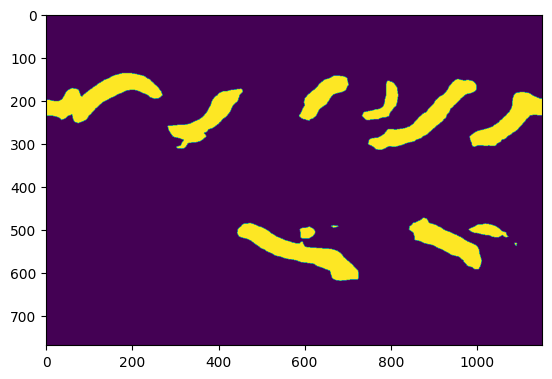

In [67]:
plt.imshow(p_high[0,:,:]>0.5)

In [49]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression( C=1000.,
        penalty='l2',
        solver='lbfgs')
lr.fit(z.reshape(-1,1), y)

A, B = lr.coef_[0,0], lr.intercept_[0]


In [50]:
print(f'A : {lr.coef_[0,0]}, B : {lr.intercept_[0]}')

A : 1.1239485761236658, B : 1.9089124904050556


In [103]:
A_low

0.1178762748837471

In [40]:
# if logits is a NumPy array
p_cal = 1 / (1 + np.exp(-(A * z + B)))       # same shape as logits

NameError: name 'A' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Flattened data (replace these with your actual arrays)
# z_flat = z.reshape(-1, 1)
# y_flat = y.reshape(-1)
# For demonstration, assume z_flat and y_flat are defined

# 1. Split into train and validation
z_train_full, z_val, y_train_full, y_val = train_test_split(
    z_flat, y_flat, test_size=0.2, random_state=42
)

# 2. Balanced subsample from training
def stratified_subsample(z, y, k_total=10000, seed=42):
    rng = np.random.default_rng(seed)
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    k_each = k_total // 2
    k_pos = min(k_each, len(pos_idx))
    k_neg = min(k_each, len(neg_idx))
    sel_pos = rng.choice(pos_idx, size=k_pos, replace=False)
    sel_neg = rng.choice(neg_idx, size=k_neg, replace=False)
    sel = np.concatenate([sel_pos, sel_neg])
    return z[sel], y[sel]

z_bal, y_bal = stratified_subsample(z_train_full, y_train_full, k_total=10000)

# 3. Fit models
lr_bal = LogisticRegression(C=1000.0, solver="lbfgs", max_iter=1000).fit(z_bal, y_bal)
lr_full = LogisticRegression(C=1000.0, solver="lbfgs", max_iter=1000).fit(z_train_full, y_train_full)

# 4. Predict on validation
p_bal = lr_bal.predict_proba(z_val)[:, 1]
p_full = lr_full.predict_proba(z_val)[:, 1]

# 5. Compute metrics
metrics = {
    "Model": ["Balanced Fit", "Full Fit"],
    "Log Loss": [log_loss(y_val, p_bal), log_loss(y_val, p_full)],
    "Brier Score": [brier_score_loss(y_val, p_bal), brier_score_loss(y_val, p_full)],
    "ROC AUC": [roc_auc_score(y_val, p_bal), roc_auc_score(y_val, p_full)],
}
metrics_df = pd.DataFrame(metrics)



# 6. Calibration curves
fig, ax = plt.subplots(figsize=(6, 6))
for name, p in [("Balanced", p_bal), ("Full", p_full)]:
    frac_pos, mean_pred = calibration_curve(y_val, p, n_bins=10)
    ax.plot(mean_pred, frac_pos, marker="o", label=name)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Empirical frequency")
ax.legend()
ax.set_title("Calibration Curves")
plt.show()


ModuleNotFoundError: No module named 'ace_tools'


Model Comparison on Validation Set:
        Model  Log Loss  Brier Score  ROC AUC
Balanced Fit  0.385882     0.115058 0.900726
    Full Fit  0.135043     0.035954 0.900726


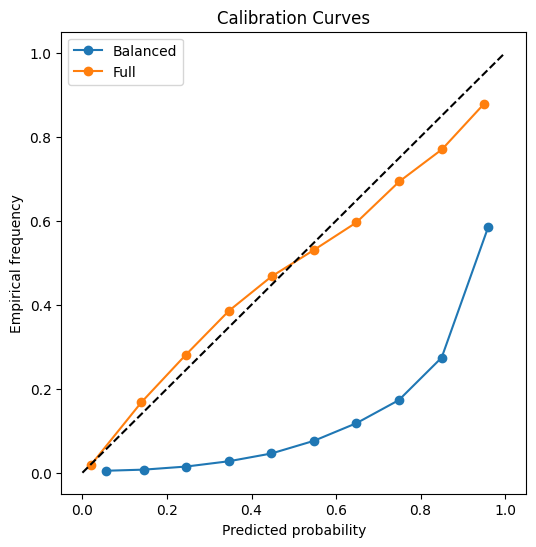

In [41]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ── 0. Prepare your data ───────────────────────────────────────────────────────
# Make sure preds and true_masks exist:
# preds: NumPy array (N, C, H, W) of logits or raw scores
# true_masks: NumPy array (N, H, W) of {0,1}

z_flat = z.reshape(-1, 1)
y_flat = y.reshape(-1)

# ── 1. Split into train / validation ───────────────────────────────────────────
z_train_full, z_val, y_train_full, y_val = train_test_split(
    z_flat, y_flat, test_size=0.2, random_state=42
)

# ── 2. Balanced subsample from training ────────────────────────────────────────
def stratified_subsample(z, y, k_total=10000, seed=42):
    rng = np.random.default_rng(seed)
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    k_half = k_total // 2
    sel = np.concatenate([
        rng.choice(pos, size=min(k_half, len(pos)), replace=False),
        rng.choice(neg, size=min(k_half, len(neg)), replace=False),
    ])
    return z[sel].reshape(-1, 1), y[sel]

z_bal, y_bal = stratified_subsample(z_train_full, y_train_full, k_total=10000)

# ── 3. Fit two logistic models ─────────────────────────────────────────────────
lr_bal  = LogisticRegression(C=1000.0, solver="lbfgs", max_iter=1000)
lr_full = LogisticRegression(C=1000.0, solver="lbfgs", max_iter=1000)

lr_bal .fit(z_bal,        y_bal)
lr_full.fit(z_train_full, y_train_full)

# ── 4. Predict on the same validation set ─────────────────────────────────────
p_bal  = lr_bal .predict_proba(z_val)[:, 1]
p_full = lr_full.predict_proba(z_val)[:, 1]

# ── 5. Compute comparison metrics ──────────────────────────────────────────────
results = {
    "Model":       ["Balanced Fit", "  Full Fit"],
    "Log Loss":    [log_loss(     y_val, p_bal),  log_loss(     y_val, p_full)],
    "Brier Score": [brier_score_loss(y_val, p_bal),  brier_score_loss(y_val, p_full)],
    "ROC AUC":     [roc_auc_score(  y_val, p_bal),  roc_auc_score(  y_val, p_full)],
}
df = pd.DataFrame(results)
print("\nModel Comparison on Validation Set:\n", df.to_string(index=False))

# ── 6. Plot calibration curves ─────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 6))
for name, p in [("Balanced", p_bal), ("Full", p_full)]:
    frac_pos, mean_pred = calibration_curve(y_val, p, n_bins=10)
    ax.plot(mean_pred, frac_pos, marker="o", label=name)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Empirical frequency")
ax.legend()
ax.set_title("Calibration Curves")
plt.show()


In [83]:
# After fitting
# Balanced‐subsample fit
A_bal, B_bal = lr_bal.coef_[0,0], lr_bal.intercept_[0]
print(f"Balanced fit →  A = {A_bal:.4f},  B = {B_bal:.4f}")

# Full‐data fit
A_full, B_full = lr_full.coef_[0,0], lr_full.intercept_[0]
print(f"Full     fit →  A = {A_full:.4f},  B = {B_full:.4f}")


Balanced fit →  A = 0.1293,  B = 0.7989
Full     fit →  A = 0.1181,  B = -2.0862


In [22]:
predictions.shape

(31, 2, 768, 1152)

In [42]:
val_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(val_loader):
    # Move data to the same device as the model
    # input_images = input_images.to(device)
    # labels = labels.to(device)
    val_mask.append(labels)

In [43]:
validation_set = ClimateDataset('/home/sbk29/data/AR/validation', model.config)
predictions_val = model.predict(validation_set)
print(predictions_val.shape)

 25%|██▌       | 1/4 [00:00<00:01,  2.07it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 2/4 [00:00<00:00,  2.09it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 3/4 [00:01<00:00,  2.10it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

Output shape : torch.Size([6, 2, 768, 1152])
(6, 2, 768, 1152)
(30, 2, 768, 1152)


In [44]:
predictions_val = np.array(predictions_val)

In [45]:
val_mask = np.array(val_mask)

In [46]:
scores_val = predictions_val[:, 1] - predictions_val[:,0]

In [47]:

z_val = scores_val.reshape(-1)          # (N·H·W,)       # same length
y_val = val_mask.reshape(-1)  

In [71]:
val_mask.shape

(30, 1, 768, 1152)

(26542080,)


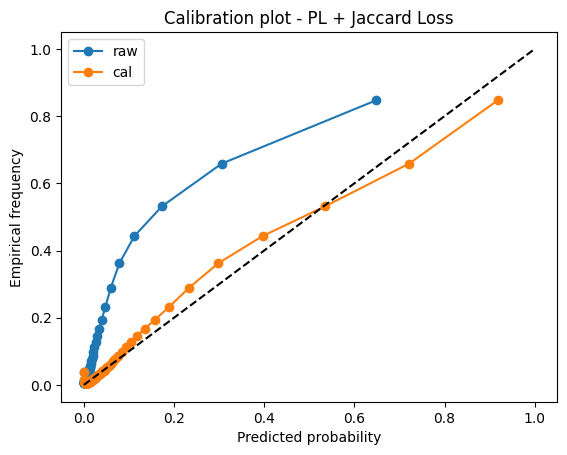

In [51]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

# flatten again
p_raw = 1/(1+np.exp(-z_val))    # uncalibrated sigmoid
p_cal = 1 / (1 + np.exp(-(A * z_val + B))) 
p_cal = np.array(p_cal)  
print(p_cal.shape)
p_cal_flat = p_cal.reshape(-1)
# p_high_flat = p_high.reshape(-1)
# print("Brier before:", brier_score_loss(y, p_raw))
# print("Brier after :", brier_score_loss(y, p_cal_flat))

# reliability diagram
for name, p in {"raw":p_raw, "cal":p_cal_flat}.items():
    frac_pos, mean_pred = calibration_curve(y_val, p, n_bins=100, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency")
plt.legend(); plt.title("Calibration plot - PL + Jaccard Loss")
plt.show()


In [52]:
p_cal = p_cal_flat.reshape(30, 768, 1152) 

In [53]:
p_raw =  p_raw.reshape(30, 768, 1152) 

In [54]:
p_cal.shape

(30, 768, 1152)

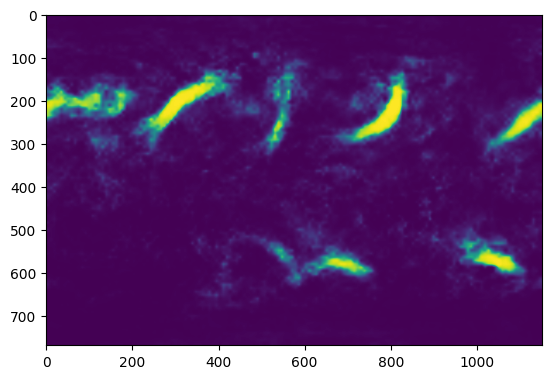

In [55]:
plt.imshow(p_cal[16,:,:])

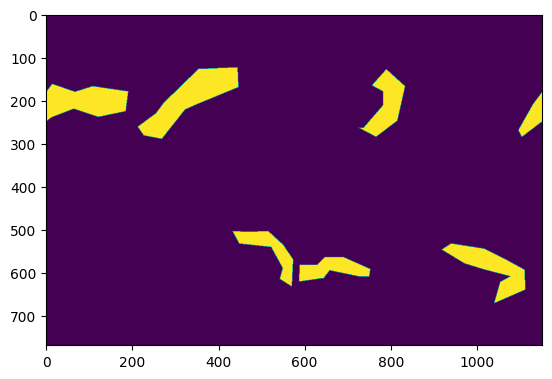

In [56]:
plt.imshow(val_mask[16,0,:,:])

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def plot_masks_on_background(true_mask,
                             p_raw,
                             p_cal,
                             background_path,
                             class_idx: int = 1,
                             num_images: int = 5,
                             cmap: str = "viridis",
                             alpha: float = 0.5):
    """
    Overlay true mask, raw probabilities, and calibrated probabilities
    on a Blue Marble background.

    Parameters
    ----------
    true_mask      : (B,H,W) or (B,1,H,W) numpy / torch
    p_raw, p_cal   : (B,H,W) or (B,C,H,W) numpy / torch
    background_path: str   path to Blue-Marble image
    class_idx      : int   which channel to visualise if multi-class
    num_images     : int   number of samples to plot
    cmap           : str   colormap for probability overlays
    alpha          : float transparency of the overlays
    """

    # ---- convert tensors → numpy -------------------------------------------
    def to_numpy(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x

    true_mask = to_numpy(true_mask)
    p_raw     = to_numpy(p_raw)
    p_cal     = to_numpy(p_cal)
     # ---- ensure shapes ------------------------------------------------------
    if true_mask.ndim == 4:               # (B,1,H,W) → (B,H,W)
        true_mask = true_mask[:, 0]

    def pick_channel(arr):
        return arr[:, class_idx] if arr.ndim == 4 else arr

    p_raw = pick_channel(p_raw)
    p_cal = pick_channel(p_cal)

    B, H, W = true_mask.shape
    num_images = min(num_images, B)

    # ---- load & resize background once -------------------------------------
    bg = Image.open(background_path).convert("RGB").resize((W, H))
    bg_np = np.asarray(bg)

    # ---- plotting grid: 3 columns per image ---------------------------------
    plt.figure(figsize=(15, 4 * num_images))

    for i in range(num_images):
        # True mask
        ax = plt.subplot(num_images, 3, 3 * i + 1)
        ax.imshow(bg_np)
        ax.imshow(true_mask[i+5], cmap="gray", alpha=alpha)
        ax.set_title(f"True Mask #{i}")
        ax.axis("off")

        # Raw probabilities
        ax = plt.subplot(num_images, 3, 3 * i + 2)
        ax.imshow(bg_np)
        im = ax.imshow(p_raw[i+5], cmap=cmap, alpha=alpha, vmin=0, vmax=1)
        ax.set_title(f"Raw Prob #{i}")
        ax.axis("off")

        # Calibrated probabilities
        ax = plt.subplot(num_images, 3, 3 * i + 3)
        ax.imshow(bg_np)
        ax.imshow(p_cal[i+5], cmap=cmap, alpha=alpha, vmin=0, vmax=1)
        ax.set_title(f"Calibrated Prob #{i}")
        ax.axis("off")

    # optional: single colorbar for the last probability image
    cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax, label="Probability")

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


In [58]:
p_raw = p_raw.reshape(30, 768, 1152) 
p_cal = p_cal.reshape(30, 768, 1152)

/tmp/ipykernel_2414606/2014614746.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


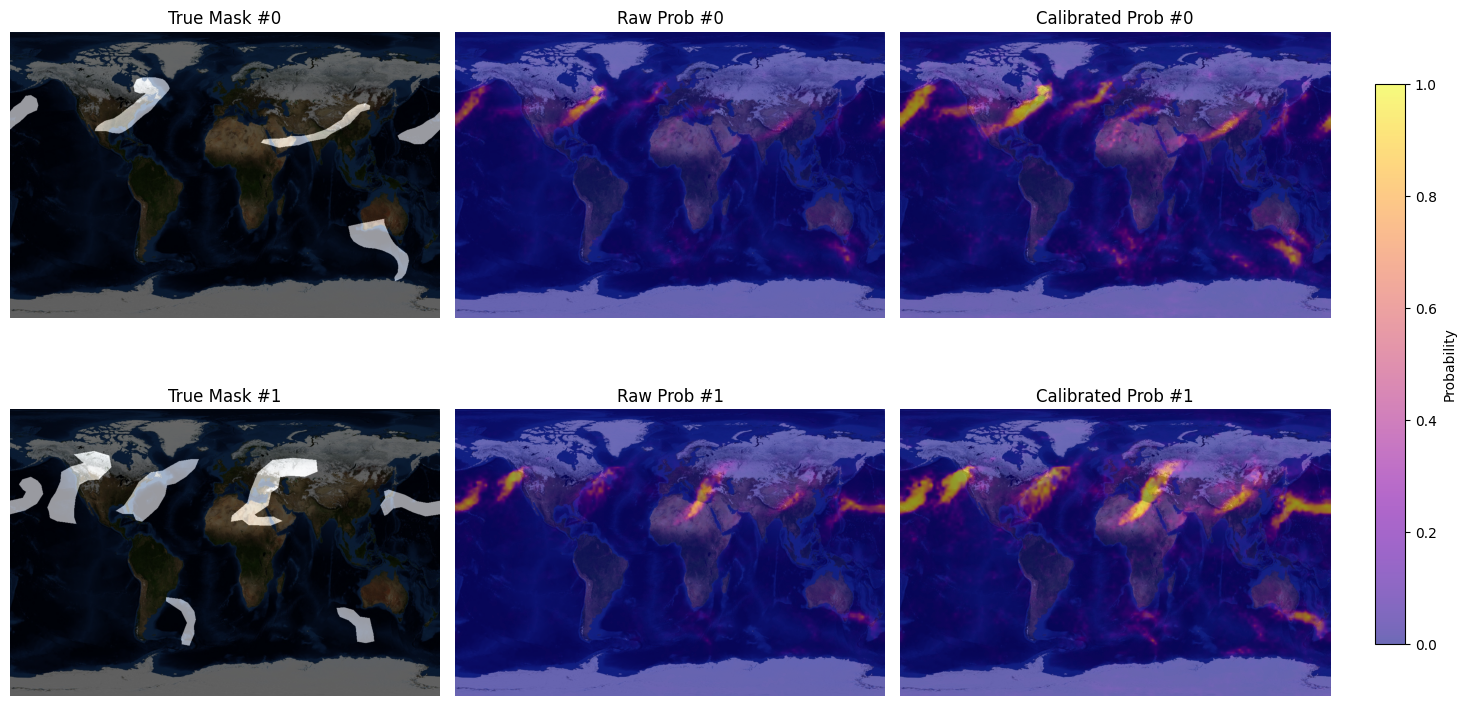

In [59]:
plot_masks_on_background(
    true_mask=val_mask,   # (31,768,1152)
    p_raw=p_raw,            # (31,768,1152) or (31,2,768,1152)
    p_cal=p_cal,            # same shape as p_raw
    background_path="/home/sbk29/data/github_AR/AR_detection/climatenet/bluemarble/BM.jpeg",
    class_idx=1,            # ignored if arrays already binary
    num_images=5,
    cmap="plasma",
    alpha=0.6
)

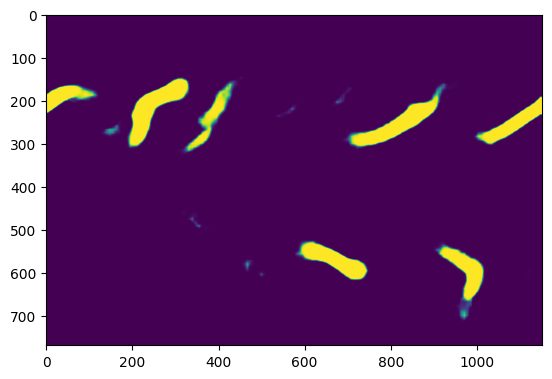

In [115]:
plt.imshow(p_raw[4])

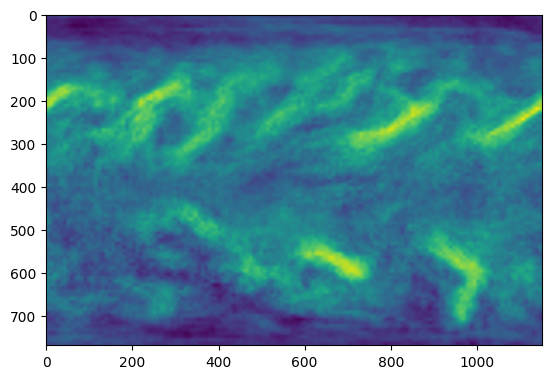

In [120]:
plt.imshow(predictions_val[3,1,:,:])

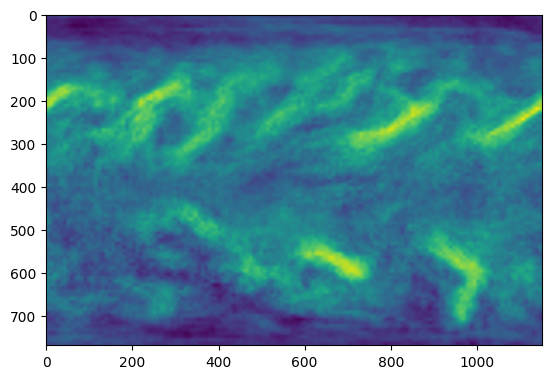

In [121]:
plt.imshow(predictions_val[4,1,:,:])

In [114]:
p_raw.shape

(30, 768, 1152)

In [118]:
predictions_val.shape

(30, 2, 768, 1152)

In [105]:
p_raw.shape

(26542080,)

In [53]:
p_raw = p_raw.reshape(30, 768, 1152) 

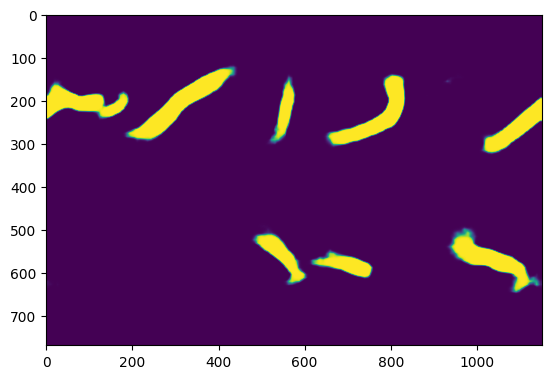

In [54]:
plt.imshow(p_raw[15,:,:])

In [40]:
B

-0.2783748894621824

In [73]:
true_mask = np.array(true_mask)

In [74]:
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = true_mask.shape[0]
scores = []

for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = true_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.38663008367138474


In [87]:
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = val_mask.shape[0]
scores = []
predicted_mask_raw = p_raw>0.5
for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = val_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask_raw[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.40332052377991295


In [88]:
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = val_mask.shape[0]
scores = []
predicted_mask_cal = p_cal>0.5
for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = val_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask_cal[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.29801005748404413


In [77]:
procrustes_loss_fn = ProcrustesLoss(
        threshold=0.5, allow_scaling=False, penalty_constant=500
    )

In [78]:
true_mask = torch.tensor(true_mask)
predicted_prob = torch.tensor(predictions_softmax)

In [79]:
procrustes_loss_fn(true_mask, predicted_prob)

tensor(125.7077)

In [144]:
predicted_prob.shape

torch.Size([61, 2, 768, 1152])

In [100]:
val_mask = torch.tensor(val_mask.squeeze())
predicted_prob_val = torch.tensor(p_cal)

/tmp/ipykernel_2032885/1468541845.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_mask = torch.tensor(val_mask.squeeze())


In [92]:
val_mask.shape

torch.Size([30, 768, 1152])

In [101]:
predicted_prob_val.shape

torch.Size([30, 768, 1152])

In [102]:
procrustes_loss_fn(val_mask, predicted_prob_val)

ValueError: Connectivity for 1D image should be in [1, ..., 1]. Got 2.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_true_predicted(background_path, true_mask, predicted_mask, num_images=3, alpha=0.4):
    """
    Overlays true and predicted masks on a background image.

    Args:
        background_path (str): Path to the background image (e.g., 'BM.jpeg')
        true_mask (ndarray): Ground truth mask (B, H, W) or (B, 1, H, W)
        predicted_mask (ndarray): Predicted mask (B, H, W)
        num_images (int): Number of images to display
        alpha (float): Transparency of the mask overlay
    """
    # Load background image
    background = Image.open(background_path).convert('RGB')
    background = np.array(background)

    # Resize to match mask size if needed
    H, W = true_mask.shape[-2:]
    bg_resized = np.array(Image.fromarray(background).resize((W, H)))

    # Remove channel from true mask if needed
    if true_mask.ndim == 4:
        true_mask = true_mask[:, 0, :, :]

    plt.figure(figsize=(10, 5 * num_images))

    for i in range(num_images):
        # True mask overlay
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(bg_resized)
        plt.imshow(true_mask[i], cmap='Reds', alpha=alpha)
        plt.title(f"Overlay: True Mask {i}")
        plt.axis('off')

        # Predicted mask overlay
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(bg_resized)
        plt.imshow(predicted_mask[i], cmap='Blues', alpha=alpha)
        plt.title(f"Overlay: Predicted Mask {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [137]:
background = '/home/sbk29/data/github_AR/AR_detection/climatenet/bluemarble/BM.jpeg'

In [138]:
# Assume you have already computed true_mask and predicted_mask
plot_true_predicted(background, true_mask, predicted_mask, num_images=5)

NameError: name 'plot_true_predicted' is not defined

In [53]:
import matplotlib.pyplot as plt

def plot_prediction_probs(predictions, class_idx=1, num_images=4, cmap='viridis'):
    """
    Plots class-specific probability maps from predictions.

    Args:
        predictions (ndarray or tensor): Shape (B, C, H, W)
        class_idx (int): Index of the class to visualize (e.g., 0 or 1)
        num_images (int): Number of samples to visualize
        cmap (str): Colormap to use (e.g., 'viridis', 'plasma', 'hot')
    """
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    plt.figure(figsize=(10, 3 * num_images))

    for i in range(num_images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(predictions[i, class_idx, :, :], cmap=cmap)
        # plt.colorbar()
        plt.title(f"Sample {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


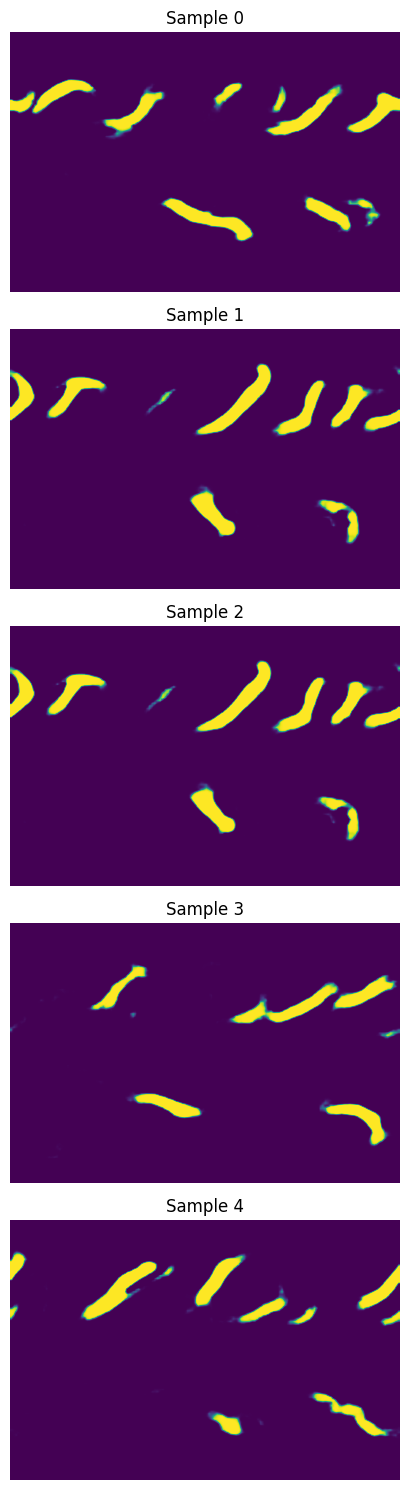

In [54]:
# predictions: shape (B, C, H, W), values ∈ [0, 1] after softmax
plot_prediction_probs(predictions_softmax, class_idx=1, num_images=5)


In [139]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def plot_masks_on_background(true_mask, predictions, background_path, class_idx=1, num_images=5, cmap='viridis', alpha=0.5):
    """
    Overlays true masks and predicted probabilities on a Blue Marble background image.

    Args:
        true_mask (tensor/ndarray): Shape (B, H, W) or (B, 1, H, W)
        predictions (tensor/ndarray): Shape (B, C, H, W)
        background_path (str): Path to the background image (e.g., 'BM.jpeg')
        class_idx (int): Class to visualize from predictions
        num_images (int): Number of samples to plot
        cmap (str): Colormap for predicted probabilities
        alpha (float): Transparency of overlays
    """
    # Convert to numpy if tensors
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(true_mask, torch.Tensor):
        true_mask = true_mask.detach().cpu().numpy()

    # Remove channel dim from true mask if present
    if true_mask.ndim == 4:
        true_mask = true_mask[:, 0, :, :]

    # Load and resize background image
    bg_img = Image.open(background_path).convert('RGB')
    H, W = true_mask.shape[-2:]
    bg_img = bg_img.resize((W, H))
    bg_np = np.array(bg_img)

    plt.figure(figsize=(12, 4 * num_images))

    for i in range(num_images):
        # Plot true mask on Blue Marble
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(bg_np)
        plt.imshow(true_mask[i], cmap='gray', alpha=alpha)
        plt.title(f"True Mask Sample {i}")
        plt.axis("off")

        # Plot prediction probs on Blue Marble
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(bg_np)
        plt.imshow(predictions[i, class_idx, :, :], cmap=cmap, alpha=alpha)
        plt.title(f"Predicted Prob of AR - Sample {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [55]:
predicted_mask = np.array(predicted_mask)

In [56]:
true_mask = np.array(true_mask)

In [57]:
tp  =  (predicted_mask == 1) & (true_mask == 1)     # just FYI
fp  =  (predicted_mask == 1) & (true_mask == 0)     # false positives
fn  =  (predicted_mask == 0) & (true_mask == 1)     # false negatives

In [23]:
fp.sum()

34005733

In [24]:
fn.sum()

37142251

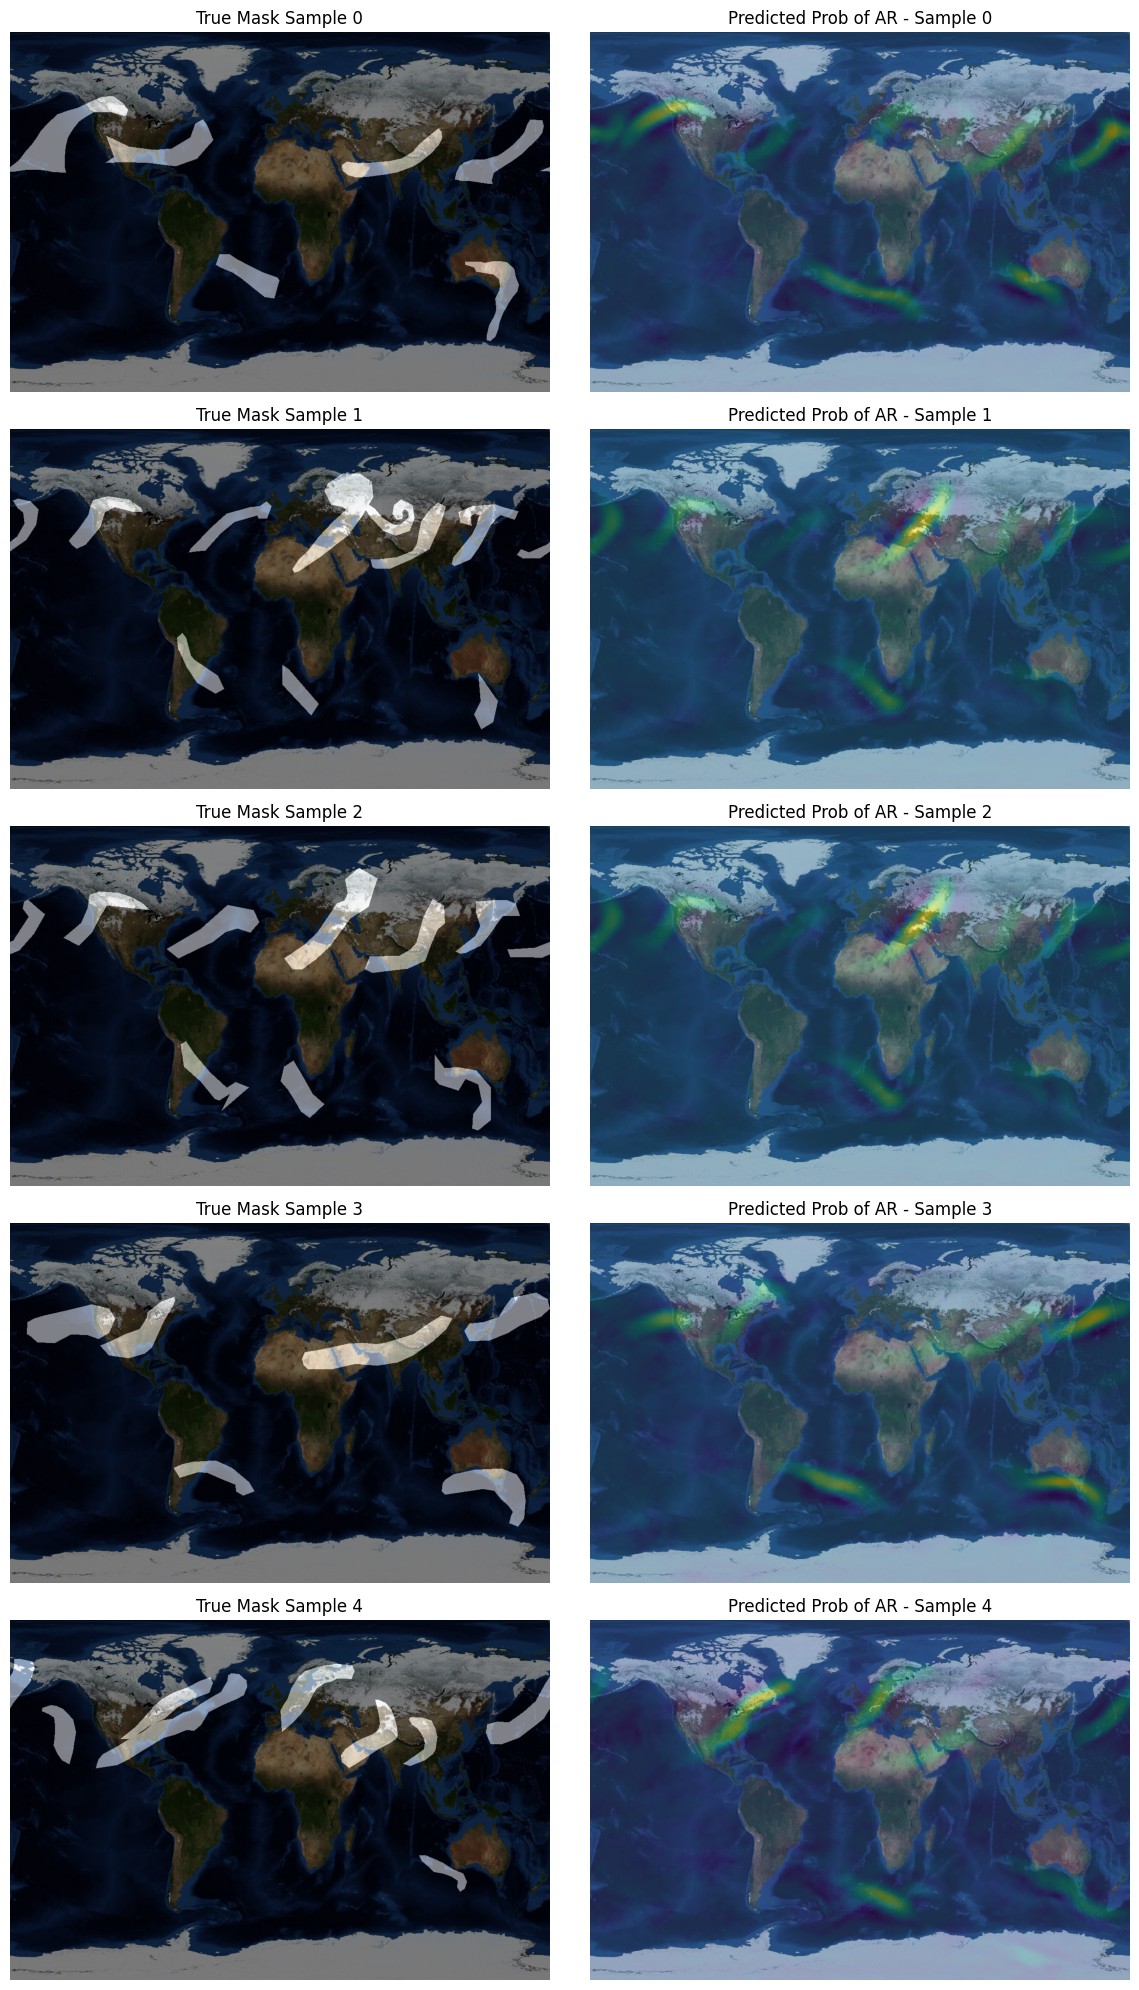

In [140]:
plot_masks_on_background(true_mask, predictions, background_path='/home/sbk29/data/ClimateNet/climatenet/bluemarble/BM.jpeg', class_idx=1, num_images=5)



In [7]:
import numpy as np
import skimage.measure
import skimage.draw
from scipy.ndimage import distance_transform_edt
from scipy.optimize import linear_sum_assignment
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
import torch.nn as nn


In [26]:
def label_and_extract_boundaries(binary_mask):
    """
    Given a 2D binary mask, label connected components and
    extract the boundary points for each labeled object.
    
    Returns a list of (label_id, boundary_points), 
    where boundary_points is an (N,2) array of [row,col].
    """
    labeled = skimage.measure.label(binary_mask, connectivity=2)
    labeled = labeled.squeeze()
    print(f'labeled shape : {labeled.shape}')
    boundaries = []
    for region_id in range(1, labeled.max() + 1):
        # A mask for just this object
        obj_mask = (labeled == region_id)
        # Find contours returns list of arrays (N,2) in y,x
        contour_list = skimage.measure.find_contours(obj_mask, level=0.5)
        # For simplicity, pick the largest contour
        if len(contour_list) > 0:
            largest_contour = max(contour_list, key=len)
            boundaries.append((region_id, largest_contour)) 
    return boundaries

In [30]:
# Fake mask with two objects
import torch
test_mask = torch.zeros(1, 64, 64, dtype=torch.bool)
test_mask[0, 10:20, 10:20] = 1
test_mask[0, 30:40, 45:55] = 1

boundaries = label_and_extract_boundaries(test_mask)
print("Objects found:", len(boundaries))
for obj_id, contour in boundaries:
    print(f"ID {obj_id}, contour points:", contour.shape)


labeled shape : (64, 64)
Objects found: 2
ID 1, contour points: (41, 2)
ID 2, contour points: (41, 2)


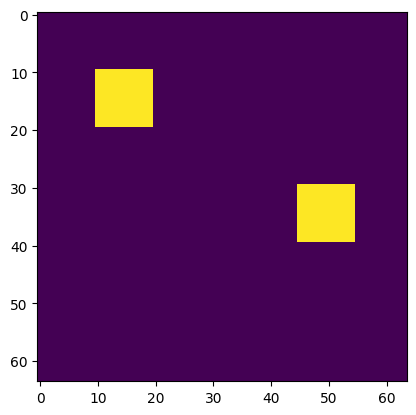

In [31]:
plt.imshow(test_mask[0,:,:])

In [32]:
import torch
import torch.nn.functional as F
from torchvision.ops import connected_components

# ────────────────────────────────────────────────────────────────────────────
# Connected‑components + boundary extraction in Torch / TorchVision
# ────────────────────────────────────────────────────────────────────────────
def label_and_extract_boundaries_torch(binary_mask: torch.Tensor,
                                       connectivity: int = 8):
    """
    Args
    ----
    binary_mask : (H, W)   or (1, H, W) torch.bool / uint8 / float tensor
                  non‑zero == foreground
    connectivity: 4 or 8 (matches skimage's 1‑ or 2‑pixel connectivity)

    Returns
    -------
    boundaries : list[(label_id: int,
                       pts: torch.LongTensor[N, 2])]   # (row, col)
                Labels start at 1 (0 = background), like skimage.
    """

    # 1) normalise shape  -> (1, 1, H, W)  (batch, channel, H, W)
    if binary_mask.ndim == 3 and binary_mask.shape[0] == 1:
        binary_mask = binary_mask.squeeze(0)
    if binary_mask.ndim != 2:
        raise ValueError("Expect (H, W) or (1, H, W) tensor.")

    if binary_mask.dtype != torch.bool:
        binary_mask = binary_mask.bool()

    x = binary_mask.unsqueeze(0).unsqueeze(0)        # [1,1,H,W]

    # 2) connected components  ───────────────────────────────────────────────
    #    TorchVision ≥ 0.17   returns int64 labels, background==0
    labeled = connected_components(x, connectivity=connectivity)[0, 0]

    # 3) edge (boundary) extraction  ─────────────────────────────────────────
    #    Use a 3×3 Laplacian kernel: pixels where the convolution ≠ 0
    laplacian = torch.tensor([[0, 1, 0],
                              [1,-4, 1],
                              [0, 1, 0]],
                             dtype=torch.float32,
                             device=binary_mask.device).view(1,1,3,3)

    boundaries = []
    for lab in torch.unique(labeled):
        if lab == 0:                          # skip background
            continue

        obj = (labeled == lab).float().unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

        # Convolution gives non‑zero exactly on border pixels
        edges = (F.conv2d(obj, laplacian, padding=1).abs() > 0)[0,0]
        pts   = edges.nonzero(as_tuple=False)          # (N, 2)  row, col

        if pts.numel():                                # skip empty / 1‑px blobs
            boundaries.append((int(lab.item()), pts))

    return boundaries


ImportError: cannot import name 'connected_components' from 'torchvision.ops' (/home/sbk29/.conda/envs/turbulence/lib/python3.12/site-packages/torchvision/ops/__init__.py)

In [114]:
import numpy as np
from typing import Tuple, Literal, Union

try:
    import torch
    _has_torch = True
except ImportError:
    _has_torch = False

Array = Union[np.ndarray, "torch.Tensor"]  # forward ref for typing

def fp_fn_percent(true_mask: Array,
                  pred_mask: Array,
                  reduction: Literal["image", "dataset"] = "image"
                 ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the percentage of false-positive (FP) and false-negative (FN)
    pixels between *binary* true and predicted masks.

    Parameters
    ----------
    true_mask  : ndarray or torch.Tensor, shape (N, H, W) or (H, W)
        Ground-truth labels (0 / 1 or False / True).
    pred_mask  : ndarray or torch.Tensor, same shape as true_mask
        Predicted labels (0 / 1 or False / True).
    reduction  : "image" | "dataset", default "image"
        • "image"   – return %FP and %FN **per image** (length N).
        • "dataset" – return a single %FP and %FN over all pixels.

    Returns
    -------
    fp_pct, fn_pct : numpy.ndarray | float
        Percentages of FP and FN pixels (0 → 100).
    """
    # --- unify to numpy for easy maths --------------------------------------
    if _has_torch and torch.is_tensor(true_mask):
        true_mask = true_mask.cpu().numpy()
    if _has_torch and torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().numpy()

    if true_mask.shape != pred_mask.shape:
        raise ValueError("true_mask and pred_mask must have the same shape")

    # Ensure boolean dtype
    true_mask = true_mask.astype(bool)
    pred_mask = pred_mask.astype(bool)

    fp =  pred_mask & ~true_mask          # False-positive pixels
    fn = ~pred_mask &  true_mask          # False-negative pixels

    if true_mask.ndim == 2:               # single image → add batch dim
        fp = fp[None, ...]
        fn = fn[None, ...]
    N, H, W = fp.shape

    if reduction == "image":
        total = H * W
        fp_pct = fp.reshape(N, -1).mean(axis=1) * 100.0   # (N,)
        fn_pct = fn.reshape(N, -1).mean(axis=1) * 100.0
    elif reduction == "dataset":
        total = N * H * W
        fp_pct = fp.sum() / total * 100.0                 # scalar
        fn_pct = fn.sum() / total * 100.0
    else:
        raise ValueError("reduction must be 'image' or 'dataset'")

    return fp_pct, fn_pct


In [119]:
true_mask = np.array(true_mask)

In [120]:
predicted_mask = np.array(predicted_mask)

In [121]:
# ---------------------------- raw arrays you have ---------------------------
# pred_mask : shape (31, 768, 1152)          dtype int/float/bool
# true_mask : shape (31, 2, 768, 1152)       one-hot

# ----------------- 1) collapse one-hot gt → single-channel binary ------------
# Option A: just take the foreground channel (class-1)
gt_bin = true_mask[:, 0]                     # shape (31, 768, 1152)
# Option B (generic): gt_bin = true_mask.argmax(axis=1)

# ----------------- 2) make sure both are boolean -----------------------------
pred_bin = (predicted_mask > 0)                   # in case it is 0/1 ints
gt_bin   = gt_bin.astype(bool)

assert pred_bin.shape == gt_bin.shape == (61, 768, 1152)

# ----------------- 3) compute percentages ------------------------------------
fp_pct, fn_pct = fp_fn_percent(gt_bin, pred_bin, reduction="image")
print("False-positive % per image:", fp_pct)
print("False-negative % per image:", fn_pct)

# ------ if you prefer a single dataset-wide number ---------------------------
fp_all, fn_all = fp_fn_percent(gt_bin, pred_bin, reduction="dataset")
print(f"Whole dataset  —  FP: {fp_all:.2f} %,  FN: {fn_all:.2f} %")

False-positive % per image: [3.16523799 2.61241772 1.66931152 1.5153673  2.24157263 1.83783637
 3.48646376 2.30272081 1.83591489 5.57612666 3.37660048 1.20397497
 1.66241681 1.00244593 1.48982295 2.31221517 3.13472041 2.59580259
 1.38640227 3.71432834 3.03988987 3.27679669 2.6614719  1.46733037
 1.90226237 3.22220414 3.26786748 1.84699164 2.15465404 2.35222711
 3.27080621 1.81410048 0.49517596 3.95044397 0.9709111  1.45681876
 2.56901494 2.18019839 3.07210286 3.64922418 1.46925184 1.45365397
 2.72002044 0.78294542 1.04053639 1.44302933 3.39728461 1.9495081
 1.68264884 3.11324508 2.44185836 3.69070548 1.14565249 3.10917607
 3.9863869  5.45134368 3.362585   4.11682129 1.46552192 0.85166649
 1.98149504]
False-negative % per image: [2.65909831 2.14210793 2.23546911 2.34408908 2.86480939 1.94611726
 1.10417119 1.31112558 2.43383337 0.50478335 3.13799823 2.05507632
 6.13584165 4.1281241  4.71711335 3.18761755 0.88885272 1.37136954
 5.52435981 2.06660518 1.64207176 3.0742504  4.62409125 2.533

In [133]:
# ---------------------------- raw arrays you have ---------------------------
# pred_mask : shape (31, 768, 1152)          dtype int/float/bool
# true_mask : shape (31, 2, 768, 1152)       one-hot

# ----------------- 1) collapse one-hot gt → single-channel binary ------------
# Option A: just take the foreground channel (class-1)
gt_bin = val_mask[:,0]               # shape (31, 768, 1152)
# Option B (generic): gt_bin = true_mask.argmax(axis=1)

# ----------------- 2) make sure both are boolean -----------------------------
pred_bin = (predicted_mask_val )                   # in case it is 0/1 ints
gt_bin   = gt_bin.astype(bool)

assert pred_bin.shape == gt_bin.shape == (30, 768, 1152)

# ----------------- 3) compute percentages ------------------------------------
fp_pct, fn_pct = fp_fn_percent(gt_bin, pred_bin, reduction="image")
print("False-positive % per image:", fp_pct)
print("False-negative % per image:", fn_pct)

# ------ if you prefer a single dataset-wide number ---------------------------
fp_all, fn_all = fp_fn_percent(gt_bin, pred_bin, reduction="dataset")
print(f"Whole dataset  —  FP: {fp_all:.2f} %,  FN: {fn_all:.2f} %")

False-positive % per image: [0.56841815 0.00983344 2.22880046 0.07923268 0.20073785 0.78622323
 0.293986   0.49483688 1.21516475 0.46578866 0.51936397 1.02618182
 0.18660934 0.25555646 0.43165419 1.51129829 0.52863227 0.18706145
 1.06935854 0.79503942 1.38956706 0.20706742 1.16531937 1.84032299
 2.26033529 1.20465314 1.4594184  0.47675239 0.18932201 0.50998264]
False-negative % per image: [3.15529152 7.10223163 2.18076353 6.34912561 2.59648076 2.78715911
 4.78018302 3.54275174 2.43937174 4.96023673 4.90191424 3.26685022
 5.64077872 5.53927951 4.90360966 2.8680872  2.80773022 3.82916486
 2.23038285 2.12594491 2.79405382 6.36133265 2.79541016 3.68245443
 1.18826407 4.01034885 1.79070367 2.7251067  6.25972041 3.08781377]
Whole dataset  —  FP: 0.79 %,  FN: 3.76 %


In [104]:
predicted_mask_val = predicted_prob_val > 0.5

In [128]:
val_mask = np.array(val_mask)


In [107]:
predicted_mask_val = np.array(predicted_mask_val)

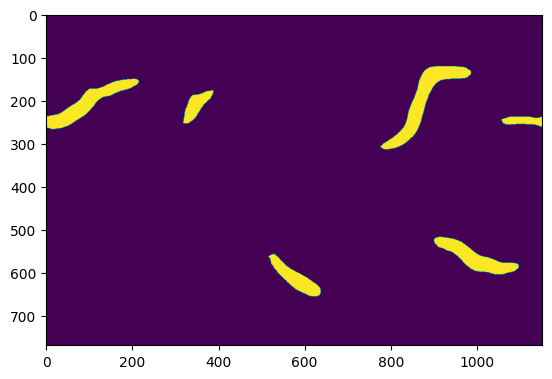

In [117]:
plt.imshow(predicted_mask_val[0,:,:])

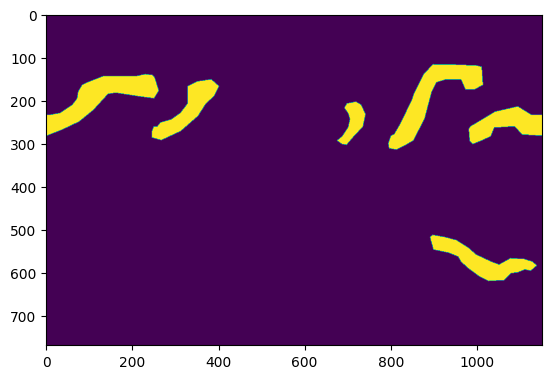

In [130]:
plt.imshow(val_mask[0,0,:,:])